# Notebook for performance evaluation of techniques

**We have four methods:**

- Raw Attention (seems to be only mean of weights from input embeddings on first layer).
- Attention flow (best in final layer).
- Attention Rollout (best in final layer).
- Gradient Attention Rollout (best in final layer (most likely)).

**We have two possible methods for metric evaluation:**

- Blank-out -> generate black spots and look at drop in accuracy.
- Gradient input -> **(?)**.

**Pipeline for evaluating models:**

- Select $N$ images for study.
- For each image (also can be done in multiple layers, but time constraint): 
    - Compute its raw attention, attention flow, rollout, and gradient rollout.
    - Compute the blank-out and gradient input.
    - Each will yield a vector of size $n_{embedding}$.
    - Compute Spearman rank correlation between them and store it

We should end up with a table of size $n_{images} \times n_{methods}$. It suffices to compute mean and standard deviation for each method.

In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
# from vit_flow2 import VITAttentionFlow
# from vit_flow_inverse import VITAttentionFlowInverse

import copy
import requests
import torch.nn.functional as F

from tqdm import tqdm

c:\Users\mouha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cpu'

In [3]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)
print()

Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


In [4]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def get_prediction(scores):
    '''Gets the index of max prob and the prob
    '''
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    # output the prediction
    return idx[0].item(), probs[0].item()

# idx, prob = get_prediction(scores)

# Generating Attention Rollout masks

In [5]:
file_attention_rollout = 'attention_rollout.txt'
file_attention_grad_rollout = 'attention_grad_rollout.txt'
file_attention_flow = 'attention_flow.txt'
# file_attention_flow_inverse = 'attention_flow2.txt'

with open(file_attention_rollout, 'w') as f:
    pass  # Opening in 'w' mode clears the file

with open(file_attention_grad_rollout, 'w') as f:
    pass  # Opening in 'w' mode clears the file

with open(file_attention_flow, 'w') as f:
    pass  # Opening in 'w' mode clears the file

# with open(file_attention_flow_inverse, 'w') as f:
#     pass  # Opening in 'w' mode clears the file

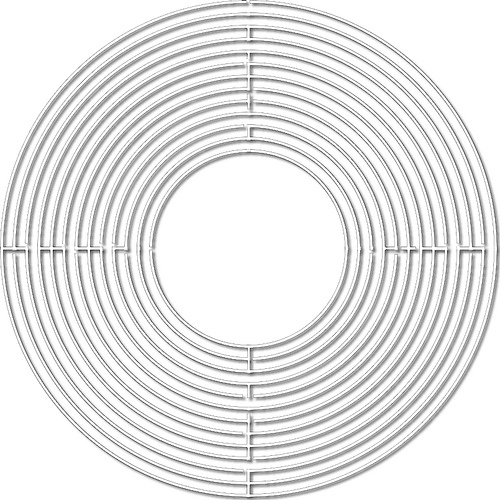

In [6]:
img = Image.open("images/ILSVRC2012_val_00000118.JPEG")
img

In [7]:
path_prefix = 'images/ILSVRC2012_val_00000'
path_suffix = '.JPEG'
discard_ratio = 0.9
image_size = 224

def convert_number(number):
    if number < 10:
        return '00'+str(number)
    if number < 100:
        return '0'+str(number)
    else:
        return str(number)

# img = Image.open(path_prefix + image_number_converted + path_suffix)

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [8]:
# for image_number in range(1,121):
#     print(f"Current image being treated: {image_number}")
    
#     if image_number in [34, 107, 118]:
#         with open(file_attention_flow_inverse, 'a') as f:
#             f.write('\n') 
#     else:
        
#         image_number_converted = convert_number(image_number)
#         image_path = path_prefix + image_number_converted + path_suffix
#         input_tensor  = preprocess_image(image_path, transform)

#         # Attention Flow Inverse
#         model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
#         model.eval()
#         attention_flow = VITAttentionFlow(model, discard_ratio=discard_ratio)
#         mask_attention_flow = attention_flow.get_attention_mask(input_tensor).numpy()
#         mask_attention_flow = mask_attention_flow / np.max(mask_attention_flow)
        
#         with open(file_attention_flow_inverse, 'a') as f:
#             np.savetxt(f, [mask_attention_flow], fmt='%.3f', delimiter=',')  # Adjust format as needed

In [9]:
for image_number in range(200,251):
    print(f"Current image being treated: {image_number}")

    if image_number in [34, 107, 118, 126, 223]:
        with open(file_attention_rollout, 'a') as f:
            f.write('\n') 
        with open(file_attention_grad_rollout, 'a') as f:
            f.write('\n')
        with open(file_attention_flow, 'a') as f:
            f.write('\n')  
    else:
        image_number_converted = convert_number(image_number)
        image_path = path_prefix + image_number_converted + path_suffix
        input_tensor  = preprocess_image(image_path, transform)

        # Getting idx
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        model.eval()
        model.to(DEVICE)
        scores = model(input_tensor)
        category_index, _ = get_prediction(scores)

        # Attention Rollout
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        model.eval()
        attention_rollout = VITAttentionRollout(model, discard_ratio=discard_ratio)
        mask_attention_rollout = attention_rollout.get_attention_mask(input_tensor).numpy()
        mask_attention_rollout = mask_attention_rollout / np.max(mask_attention_rollout)
        
        with open(file_attention_rollout, 'a') as f:
            np.savetxt(f, [mask_attention_rollout], fmt='%.3f', delimiter=',')  # Saving as float

        # Gradient Attention Rollout
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        model.eval()
        attention_grad_rollout = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask_attention_grad_rollout = attention_grad_rollout.get_attention_mask(input_tensor, category_index=category_index).numpy()
        mask_attention_grad_rollout = mask_attention_grad_rollout / np.max(mask_attention_grad_rollout)
        
        with open(file_attention_grad_rollout, 'a') as f:
            np.savetxt(f, [mask_attention_grad_rollout], fmt='%.3f', delimiter=',')  # Adjust format as needed

        # Attention Flow
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        model.eval()
        attention_flow = VITAttentionFlow(model, discard_ratio=discard_ratio)
        mask_attention_flow = attention_flow.get_attention_mask(input_tensor).numpy()
        mask_attention_flow = mask_attention_flow / np.max(mask_attention_flow)
        
        with open(file_attention_flow, 'a') as f:
            np.savetxt(f, [mask_attention_flow], fmt='%.3f', delimiter=',')  # Adjust format as needed
        

Current image being treated: 200


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
c:\Users\mouha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [18:36<00:00,  5.67s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 201


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:30<00:00,  1.98s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 202


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 203


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 204


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 205


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:09<00:00,  1.87s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 206


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 207


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 208


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:11<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 209


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:13<00:00,  1.90s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 210


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:27<00:00,  1.96s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 211


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 212


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:13<00:00,  1.90s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 213


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 214


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:11<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 215


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 216


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:09<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 217


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:09<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 218


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 219


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 220


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:23<00:00,  1.95s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 221


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 222


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 223
Current image being treated: 224


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 225


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 226


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 227


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 228


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:11<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 229


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:11<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 230


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:10<00:00,  1.88s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 231


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:12<00:00,  1.89s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 232


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:34<00:00,  2.00s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 233


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [1:37:25<00:00, 29.67s/it]  
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 234


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [18:25<00:00,  5.61s/it]  
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 235


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [10:48<00:00,  3.29s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 236


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [10:41<00:00,  3.26s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 237


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [11:11<00:00,  3.41s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 238


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [10:30<00:00,  3.20s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 239


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [10:35<00:00,  3.23s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 240


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [12:10<00:00,  3.71s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 241


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [10:49<00:00,  3.30s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 242


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [12:43<00:00,  3.87s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 243


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [13:25<00:00,  4.09s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 244


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [07:08<00:00,  2.17s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 245


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:07<00:00,  1.87s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 246


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:07<00:00,  1.87s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 247


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [06:08<00:00,  1.87s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 248


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [07:31<00:00,  2.29s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 249


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [07:19<00:00,  2.23s/it]
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


Current image being treated: 250


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main
100%|██████████| 197/197 [09:36<00:00,  2.93s/it]


In [10]:
# import requests
# import torch.nn.functional as F

# LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
# classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

In [11]:
# input_tensor  = preprocess_image("examples/input.png", transform)
# scores = model(input_tensor)

# def print_preds(scores):
#     # print the predictions with their 'probabilities' from the scores
#     h_x = F.softmax(scores, dim=1).data.squeeze()
#     probs, idx = h_x.sort(0, True)
#     probs = probs.numpy()
#     idx = idx.numpy()
#     # output the prediction
#     for i in range(0, 5):
#         print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
#     return idx

# def get_prediction(scores):
#     '''Gets the index of max prob and the prob
#     '''
#     h_x = F.softmax(scores, dim=1).data.squeeze()
#     probs, idx = h_x.sort(0, True)
#     # output the prediction
#     return idx[0].item(), probs[0].item()

# idx, prob = get_prediction(scores)